## Scikit-optimize Hyperparameter optimisation notebook 
[Main notebook link](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html)

* [Scikit-optimize](https://scikit-optimize.github.io/stable/)
* [HyperOpt](https://github.com/hyperopt/hyperopt)

In [1]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

In [2]:
# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [5]:
y_pred.shape

(127,)

R2: 0.861 | RMSE: 3.119


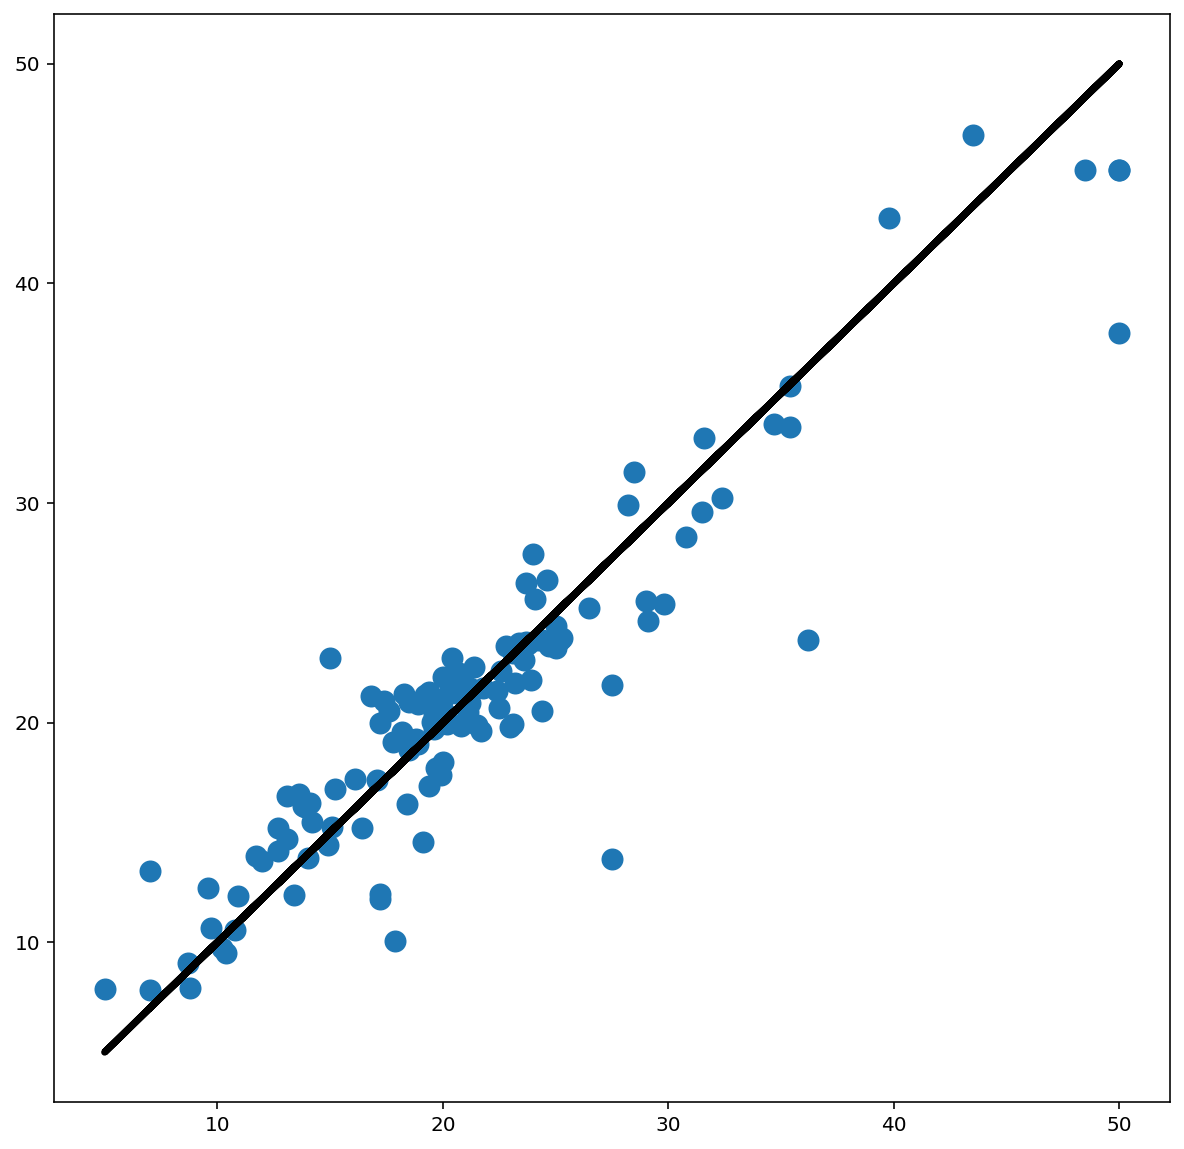

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(y_test, y_pred, s=100)
ax.plot(y_test, y_test, linewidth=3.5, color='k')

_r2 = r2_score(y_test, y_pred)
_rmse = np.sqrt( mean_squared_error(y_test, y_pred) )
print('R2: {0:0.3f} | RMSE: {1:0.3f}'.format(_r2, _rmse))

## ## CROSS-VALIDATION 

In [7]:
from sklearn.model_selection import cross_val_score, cross_validate

def display_scores(scores, metric):
    #print("Scores:", scores)
    score_key = 'test_{}'.format(metric)
    print(metric)
    print("Mean:", scores[score_key].mean())
    print("Standard deviation:", scores[score_key].std())

In [8]:
_scoring = ["neg_mean_squared_error"]
forest_scores = cross_validate(reg, X_train, y_train, scoring=_scoring, cv=10)

In [9]:
display_scores(forest_scores, "neg_mean_squared_error")

neg_mean_squared_error
Mean: -12.30979411248526
Standard deviation: 6.438051642251604


### ### Hyperparameter search

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from dask.distributed import Client
import joblib

In [11]:
client = Client() 

In [12]:
client

Client Scheduler: tcp://127.0.0.1:50888 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [13]:
RF_reg = GradientBoostingRegressor(random_state=42)
param_grid = { 
    'min_samples_leaf': [2, 5, 10, 100],
    'min_samples_split': [2, 5, 10, 100],
    'n_estimators': [100, 200, 400, 700],
    'max_depth': [5,10,15,20]
}

In [14]:
CV_rfr = RandomizedSearchCV(estimator=RF_reg, n_iter=10, param_distributions=param_grid, scoring="neg_mean_squared_error", cv= 5, verbose=1, n_jobs=-1, refit=True)

In [15]:
%%time 
with joblib.parallel_backend('dask'):
    CV_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished


CPU times: user 904 ms, sys: 100 ms, total: 1 s
Wall time: 6.28 s


In [16]:
print(CV_rfr.best_params_)

{'n_estimators': 100, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 20}


In [17]:
pd.DataFrame(CV_rfr.cv_results_).sort_values('rank_test_score', )

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.274650,0.053841,0.001172,0.000254,100,100,5,20,"{'n_estimators': 100, 'min_samples_split': 100...",-8.671213,-15.289582,-10.374475,-8.687919,-15.072023,-11.619043,2.974090,1
7,0.477478,0.029693,0.001845,0.000511,200,100,10,15,"{'n_estimators': 200, 'min_samples_split': 100...",-8.401892,-15.424825,-8.321938,-9.096511,-16.935994,-11.636232,3.750642,2
1,1.561276,0.072511,0.002847,0.000252,700,10,2,5,"{'n_estimators': 700, 'min_samples_split': 10,...",-8.822571,-16.990815,-9.008891,-10.817529,-14.450938,-12.018149,3.204831,3
3,0.412332,0.026131,0.002115,0.001273,100,5,5,20,"{'n_estimators': 100, 'min_samples_split': 5, ...",-10.234256,-24.301139,-9.872093,-10.908084,-18.425869,-14.748288,5.721582,4
6,1.560921,0.223534,0.003291,0.000463,400,2,5,15,"{'n_estimators': 400, 'min_samples_split': 2, ...",-10.471399,-24.433166,-10.317219,-11.374612,-18.095469,-14.938373,5.552075,5
2,1.019774,0.044190,0.002798,0.000188,200,2,2,20,"{'n_estimators': 200, 'min_samples_split': 2, ...",-10.095146,-19.497136,-11.246545,-17.691678,-17.670148,-15.240131,3.806751,6
0,0.935529,0.051472,0.002642,0.000519,200,2,2,15,"{'n_estimators': 200, 'min_samples_split': 2, ...",-9.923940,-19.651046,-11.229205,-17.900744,-17.577677,-15.256523,3.907614,7
4,0.104271,0.012265,0.000832,0.000134,100,5,100,15,"{'n_estimators': 100, 'min_samples_split': 5, ...",-26.314055,-29.064783,-40.558458,-26.370188,-34.330570,-31.327611,5.460009,8
5,0.100944,0.023998,0.000724,0.000050,100,10,100,5,"{'n_estimators': 100, 'min_samples_split': 10,...",-26.314055,-29.064783,-40.558458,-26.370188,-34.330570,-31.327611,5.460009,8
9,0.082421,0.007593,0.000750,0.000139,100,5,100,10,"{'n_estimators': 100, 'min_samples_split': 5, ...",-26.314055,-29.064783,-40.558458,-26.370188,-34.330570,-31.327611,5.460009,8


In [18]:
best_model = CV_rfr.best_estimator_

In [19]:
best_model

GradientBoostingRegressor(max_depth=20, min_samples_leaf=5,
                          min_samples_split=100, random_state=42)

In [20]:
y_pred = best_model.predict(X_test)

R2: 0.871 | RMSE: 3.000


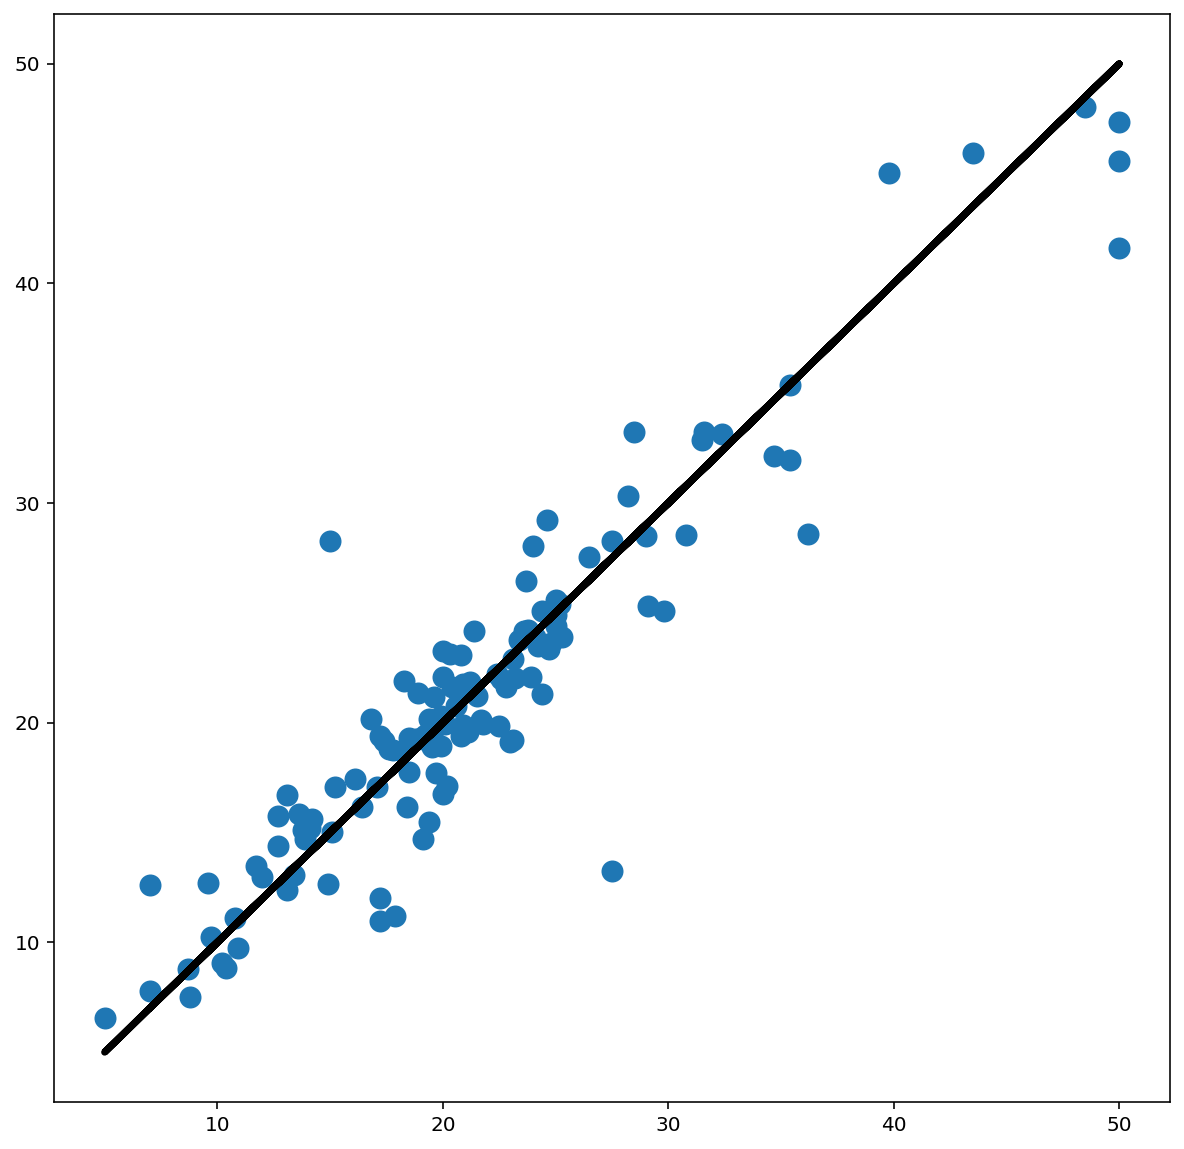

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(y_test, y_pred, s=100)
ax.plot(y_test, y_test, linewidth=3.5, color='k')

_r2 = r2_score(y_test, y_pred)
_rmse = np.sqrt( mean_squared_error(y_test, y_pred) )
print('R2: {0:0.3f} | RMSE: {1:0.3f}'.format(_r2, _rmse))

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
#Same thing but with BayesSearchCV
from skopt import BayesSearchCV
import time as time
import scipy.stats as stats
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from dask.distributed import Client
import joblib

params  = {
        'max_depth':Integer(1, 5),
        'learning_rate':Real(10**-5, 10**0, prior="log-uniform"),
        'max_features':Integer(1, n_features),
        'min_samples_split':Integer(2, 100),
        'min_samples_leaf':Integer(1, 100)
        }

search = BayesSearchCV(
    reg,
    params,
    n_iter=50,
    cv=5,
    n_jobs=1,
    random_state=0)

start = time.time()
with joblib.parallel_backend('dask'):
    search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time.time() - start, len(search.cv_results_['params'])))
report(search.cv_results_)
best_model = search.best_params_
print('Best model')
print(best_model)

In [ ]:
_Bayes_best_model = GradientBoostingRegressor(random_state=42, **best_model)
_Bayes_best_model.fit(X_train, y_train)
y_pred_bayes = _Bayes_best_model.predict(X_test)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(y_test, y_pred_bayes, s=100)
ax.plot(y_test, y_test, linewidth=3.5, color='k')

_r2 = r2_score(y_test, y_pred_bayes)
_rmse = np.sqrt( mean_squared_error(y_test, y_pred_bayes) )
print('R2: {0:0.3f} | RMSE: {1:0.3f}'.format(_r2, _rmse))

In [ ]:
from skopt.plots import plot_convergence
plot_convergence(search)
plt.show()

In [ ]:
len(search.cv_results_['mean_test_score'])